# Строгий шаг времени

1. сделать нормализацию таймстемпов, чтобы начинались они в нуле
3. сделать строгий шаг 20mc
4. сигналы приходят "лесенкой"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path
import json
from glob import glob
from tqdm import tqdm
import os

In [2]:
avg_req = []
avg_loc = []
min_req = []
max_req = []
min_loc = []
max_loc = []
for d in tqdm(list(glob('YandexCup2024v2/YaCupTest/*'))):
    s_ns = pd.read_csv(f'{d}/localization.csv').stamp_ns.values
    diff = s_ns[1:] - s_ns[:-1]
    avg_loc.append(diff.mean())
    min_loc.append(diff.min())
    max_loc.append(diff.max())
    s_ns = pd.read_csv(f'{d}/requested_stamps.csv').stamp_ns.values
    diff = s_ns[1:] - s_ns[:-1]
    avg_req.append(diff.mean())
    min_req.append(diff.min())
    max_req.append(diff.max())
for a in [avg_req, 
        avg_loc,
        min_req,
        max_req,
        min_loc,
        max_loc]:
    print(f"{round(np.mean(a)):010d}, {round(np.max(a)):010d}, {round(np.min(a)):010d}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:48<00:00, 166.33it/s]

0040015627, 0040905935, 0039980080
0040013963, 0043666637, 0039869437
0037551264, 0039456712, 0019508802
0046804422, 0165592645, 0040715438
0038335620, 0039526460, 0020311755
0043259035, 0136663118, 0040464301


In [3]:
NSECS_IN_SEC = 1000000000


def interpolate_2d(A_x, B_x, T_x, A_y, B_y):
    """Predicts T_y by linear interpolating A and B dots"""
    assert A_x <= B_x , f"{A_x=} must be less than {B_x}"
    assert A_x <= T_x , f"{A_x=} must be less than {T_x}"
    delta_y = (B_y - A_y) / (B_x - A_x) * (T_x - A_x)
    return A_y + delta_y


def inperpolate_dots(A_x, A, B_x, B, T_x):
    if A is None or B is None:
        # if A does not exist then just B returned
        return B
    assert len(A) == len(B), f"{len(A)=}, {len(B)=}"
    T = [interpolate_2d(A_x, B_x, T_x, A_y, B_y) for A_y, B_y in zip(A, B)]
    return T


# 200000000нс == 200мс
def quantisize_time(time, variables, start_time=None, frame_step=200000000, interpolate_type='linear'):
    # time is (T,)
    # variables is (T, N)
    assert time.shape[0] == variables.shape[0], f"{time.shape=} {variables.shape=}"
    #print(f"Frame step is {frame_step/NSECS_IN_SEC}s == {frame_step/NSECS_IN_SEC*1000}mc")
    if start_time is None:
        start_time = np.min(time)
    # moves start to zero
    time = time - start_time 
    num_frames = math.ceil(np.max(time)/frame_step)
    dots_in_frames = [[] for _ in range(num_frames)]
    frames = []
    prev_t = None
    prev_dot = None
    prev_frame_id = -1
    for t, v in zip(time, variables):
        frame_id = int(t // frame_step)
        if frame_id != prev_frame_id:
            for i in range(prev_frame_id + 1, frame_id + 1):
                frame_vars = inperpolate_dots(prev_t, prev_dot, t, v, i * frame_step)
                frames.append([i, *frame_vars])
        prev_t = t
        prev_dot = v
        prev_frame_id = frame_id
    return (start_time, np.asarray(frames, dtype=float))

 

In [4]:
interpolate_2d(1, 3, 2, -10, -20)

-15.0

In [5]:
inperpolate_dots(1, (-10, 10, 2), 3, (30, -20, 4), 2)

[10.0, -5.0, 3.0]

In [6]:
localization_df = pd.read_csv('YandexCup2024v2/YaCupTest/0/localization.csv')

In [7]:
time = localization_df.stamp_ns.values
feats = np.hstack((localization_df.x.values[:, None], 
                   localization_df.y.values[:, None], 
                   localization_df.z.values[:, None],
                   localization_df.roll.values[:, None], 
                   localization_df.pitch.values[:, None], 
                   localization_df.yaw.values[:, None]))
frames_loc = quantisize_time(time, feats)

In [10]:
frames_loc[1].shape

(25, 7)

In [58]:
!ls YandexCup2024v2/YaCupTrain/0
!ls YandexCup2024v2/YaCupTest/0
!head YandexCup2024v2/YaCupTest/0/requested_stamps.csv

control.csv	     control_norm_v1-quant20mc.csv  localization-quant20mc.csv
control_norm_v1.csv  localization.csv		    metadata.json
control.csv		       localization-quant20mc.csv
control_norm_v1.csv	       metadata.json
control_norm_v1-quant20mc.csv  requested_stamps.csv
localization.csv	       requested_stamps-quant20mc.csv
stamp_ns
5000888836
5040043013
5079989560
5120797471
5165218288
5200882920
5240761596
5279997787
5320208650


In [11]:
VERSION='v3'
def quant_dir(d):
    df = pd.read_csv(f'{d}/control_norm_v1.csv')
    st, data = quantisize_time(df.values[:, 0], df.values[:, 1:], start_time=None, frame_step=20000000)
    pd.DataFrame(data, columns=df.columns).to_csv(f'{d}/control_norm_v1-quant20mc_{VERSION}.csv', index=False)

    df = pd.read_csv(f'{d}/localization.csv')
    _, data = quantisize_time(df.values[:, 0], df.values[:, 1:], start_time=st, frame_step=20000000)
    pd.DataFrame(data, columns=df.columns).to_csv(f'{d}/localization-quant20mc_{VERSION}.csv', index=False)

    f=f'{d}/requested_stamps.csv'
    if os.path.exists(f):
        df = pd.read_csv(f'{d}/requested_stamps.csv')
        df.stamp_ns = df.stamp_ns - st
        df.to_csv(f'{d}/requested_stamps-quant20mc_{VERSION}.csv', index=False)
    with open(f"{d}/quant20mc_{VERSION}", 'w') as f:
        f.write(f'{st}')

quant_dir('YandexCup2024v2/YaCupTrain/0')
quant_dir('YandexCup2024v2/YaCupTest/0')

In [12]:
!ls YandexCup2024v2/YaCupTrain/0
!ls YandexCup2024v2/YaCupTest/0
!head YandexCup2024v2/YaCupTest/0/requested_stamps.csv
!head YandexCup2024v2/YaCupTest/0/requested_stamps-quant20mc.csv
!head YandexCup2024v2/YaCupTest/0/quant20mc


control.csv			  localization-quant20mc_v2.csv
control_norm_v1.csv		  localization-quant20mc_v3.csv
control_norm_v1-quant20mc.csv	  metadata.json
control_norm_v1-quant20mc_v2.csv  quant20mc
control_norm_v1-quant20mc_v3.csv  quant20mc_v3
localization.csv		  speed-norm-quant20mc_v2.csv
localization-quant20mc.csv	  speed-quant20mc_v2.csv
control.csv			  metadata.json
control_norm_v1.csv		  quant20mc
control_norm_v1-quant20mc.csv	  quant20mc_v3
control_norm_v1-quant20mc_v2.csv  requested_stamps.csv
control_norm_v1-quant20mc_v3.csv  requested_stamps-quant20mc.csv
localization.csv		  requested_stamps-quant20mc_v2.csv
localization-quant20mc.csv	  requested_stamps-quant20mc_v3.csv
localization-quant20mc_v2.csv	  speed-norm-quant20mc_v2.csv
localization-quant20mc_v3.csv	  speed-quant20mc_v2.csv
stamp_ns
5000888836
5040043013
5079989560
5120797471
5165218288
5200882920
5240761596
5279997787
5320208650
stamp_ns
4964409344.0
5003563521.0
5043510068.0
5084317979.0
5128738796.0
5164403428.0
520428210

In [35]:
data.shape

Frame step is 0.02s == 20.0mc


(2998, 5)

,stamp_ns,acceleration_level,steering,norm_acceleration_level,norm_steering
0,0.0,-114.000000,-2.655140,-0.451500,-0.061511
1,1.0,-118.511240,-2.626583,-0.481215,-0.061013
2,2.0,-123.022736,-2.598033,-0.510931,-0.060515
3,3.0,-127.585242,-2.570787,-0.540984,-0.060039
4,4.0,-132.145855,-2.544422,-0.571024,-0.059579


In [13]:
def plot_a_s(times, acceleration_levels, steerings):
    # Создаем фигуру и оси
    fig, ax1 = plt.subplots()
    
    # Рисуем график для acceleration_level
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Acceleration Level', color=color)
    for t, a in zip(times, acceleration_levels):
        ax1.plot(t, a, color=color, label='Acceleration Level')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Создаем второй объект оси для steering
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Steering', color=color)
    for t, s in zip(times, steerings):
        ax2.plot(t, s, color=color, label='Steering')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Добавляем заголовок и легенду
    plt.title('Acceleration Level and Steering Over Time')
    fig.tight_layout()  # adjusts layout to avoid overlap
    plt.show()

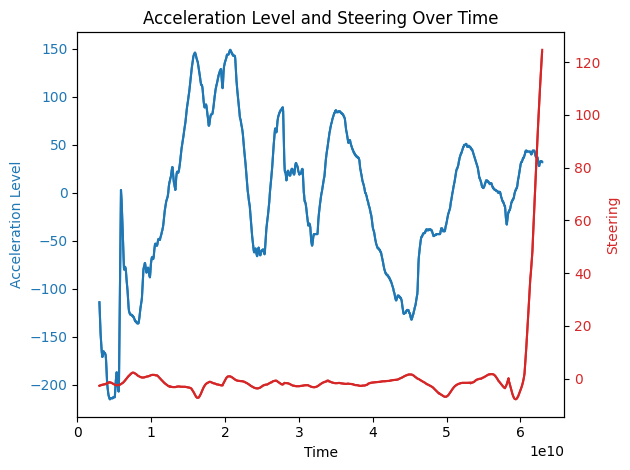

In [51]:
plot_a_s([df['stamp_ns'].values,df2['stamp_ns'].values*20000000+st],  
         [df['acceleration_level'].values, df2['acceleration_level'].values], 
         [df['steering'].values, df2['steering'].values])
#plot_a_s(df2['stamp_ns'].values, [], [])

In [15]:
dataset_info = []
for d in tqdm([*glob('YandexCup2024v2/YaCupTrain/*'), *glob('YandexCup2024v2/YaCupTest/*')]):
    quant_dir(d)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [1:30:04<00:00,  9.25it/s]


In [65]:
!head YandexCup2024v2/YaCupTest/0/requested_stamps-quant20mc.csv

stamp_ns
4964409344.0
5003563521.0
5043510068.0
5084317979.0
5128738796.0
5164403428.0
5204282104.0
5243518295.0
5283729158.0


In [66]:
!head YandexCup2024v2/YaCupTest/0/requested_stamps.csv

stamp_ns
5000888836
5040043013
5079989560
5120797471
5165218288
5200882920
5240761596
5279997787
5320208650
